In [0]:
import json
!mkdir .kaggle
token = {"username":"raviraj0104","key":"acfb5ca1842ad1423bb1da3f6d5cd7b5"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json


mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}


In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --force


100% 2.29G/2.29G [00:53<00:00, 56.0MB/s]
100% 2.29G/2.29G [00:54<00:00, 45.5MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [0]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [114]:
IMG_SIZE = 200
labels = ['PNEUMONIA','NORMAL']

pneumonia_count = 0
normal_count = 0
def get_training_data(data_dir):
  training_data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for f in tqdm(os.listdir(path)):
      try:
        filepath = os.path.join(path, f)
        img = cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),labels.index(label)])

        if label == labels[0]:
          pneumonia_count += 1
        if label == labels[1]:
          normal_count += 1
      except:
        pass

  np.random.shuffle(training_data)
  #np.save("training_data_xray.npy",self.training_data)
  return training_data
        

dirpaths = ['chest_xray/train/','chest_xray/test/','chest_xray/val/']

train = get_training_data(dirpaths[0])

test = get_training_data(dirpaths[1])

val = get_training_data(dirpaths[2])

100%|██████████| 8/8 [00:00<00:00, 92.89it/s]


In [0]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)

0


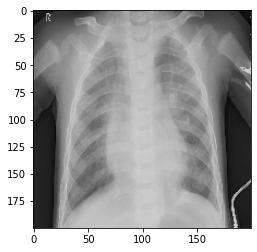

In [116]:
plt.imshow(X[15],cmap='gray')
print(y[15])

In [0]:
del(train)
del(test)
del(val)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
from collections import Counter

In [0]:
from torchvision import models
model = models.resnet50(pretrained=True)

In [0]:
#for name, child in model.fc.named_children():  
  #for name2, param in child.named_parameters():
    #param.requires_grad = True

In [121]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.6),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
X = torch.tensor([i for i in X]).view(-1,200,200)
X = torch.stack([i.view(200,200,1).expand(-1,-1,3) for i in X])
y = torch.tensor([i for i in y])


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=32,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=32,stratify=y_temp)

In [123]:
len(X_train),len(X_test),len(X_val)

(3513, 1171, 1172)

In [0]:
del(X_temp)
del(y_temp)

In [125]:
BATCH_SIZE= 100
epochs = 10
steps = 0
running_loss = 0
print_every = 20
train_losses, test_losses = [], []

for epoch in range(epochs):
    for i in tqdm(range(0,len(X_train),BATCH_SIZE)):
        steps += 1
        batch_x = X_train[i:i+BATCH_SIZE].view(-1,3,200,200)
        batch_y = y_train[i:i+BATCH_SIZE]
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        model.zero_grad()
        output = model.forward((batch_x.float()))
        loss = criterion(output,batch_y.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for i in range(0,len(X_val),BATCH_SIZE):
                  inputs = X_val[i:i+BATCH_SIZE].view(-1,3,200,200)
                  labels = y_val[i:i+BATCH_SIZE]
                  inputs, labels = inputs.to(device),labels.to(device)
                  logps = model.forward(inputs.view(-1,3,200,200).float())
                  batch_loss = criterion(logps, labels.long())
                  test_loss += batch_loss.item()

                  ps = torch.exp(logps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          train_losses.append(running_loss/len(X_train))
          test_losses.append(test_loss/len(X_val))                    
          print(f"Epoch {epoch+1}/{epochs}.. Train loss: {running_loss/len(X_train):.3f}.. Test loss: {test_loss/len(X_val):.3f}.. Test accuracy: {accuracy*BATCH_SIZE*100/len(X_val):.3f}")
          running_loss = 0
          model.train()

 56%|█████▌    | 20/36 [00:08<00:18,  1.15s/it]

Epoch 1/10.. Train loss: 0.004.. Test loss: 0.005.. Test accuracy: 75.498


 11%|█         | 4/36 [00:04<00:37,  1.16s/it]

Epoch 2/10.. Train loss: 0.003.. Test loss: 0.004.. Test accuracy: 90.112


 67%|██████▋   | 24/36 [00:12<00:14,  1.17s/it]

Epoch 2/10.. Train loss: 0.002.. Test loss: 0.003.. Test accuracy: 89.206


 22%|██▏       | 8/36 [00:05<00:33,  1.18s/it]

Epoch 3/10.. Train loss: 0.002.. Test loss: 0.003.. Test accuracy: 90.538


 78%|███████▊  | 28/36 [00:13<00:09,  1.19s/it]

Epoch 3/10.. Train loss: 0.002.. Test loss: 0.003.. Test accuracy: 91.287


 33%|███▎      | 12/36 [00:06<00:28,  1.20s/it]

Epoch 4/10.. Train loss: 0.002.. Test loss: 0.003.. Test accuracy: 88.661


 89%|████████▉ | 32/36 [00:15<00:04,  1.21s/it]

Epoch 4/10.. Train loss: 0.002.. Test loss: 0.003.. Test accuracy: 92.089


 44%|████▍     | 16/36 [00:07<00:24,  1.22s/it]

Epoch 5/10.. Train loss: 0.002.. Test loss: 0.003.. Test accuracy: 92.326


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/10.. Train loss: 0.001.. Test loss: 0.003.. Test accuracy: 91.780


 56%|█████▌    | 20/36 [00:08<00:19,  1.24s/it]

Epoch 6/10.. Train loss: 0.002.. Test loss: 0.002.. Test accuracy: 92.174


 11%|█         | 4/36 [00:04<00:39,  1.25s/it]

Epoch 7/10.. Train loss: 0.001.. Test loss: 0.003.. Test accuracy: 92.070


 67%|██████▋   | 24/36 [00:13<00:15,  1.26s/it]

Epoch 7/10.. Train loss: 0.001.. Test loss: 0.003.. Test accuracy: 92.089


 22%|██▏       | 8/36 [00:05<00:35,  1.27s/it]

Epoch 8/10.. Train loss: 0.002.. Test loss: 0.003.. Test accuracy: 92.240


 78%|███████▊  | 28/36 [00:14<00:10,  1.29s/it]

Epoch 8/10.. Train loss: 0.001.. Test loss: 0.002.. Test accuracy: 92.548


 33%|███▎      | 12/36 [00:06<00:31,  1.30s/it]

Epoch 9/10.. Train loss: 0.002.. Test loss: 0.003.. Test accuracy: 89.311


 89%|████████▉ | 32/36 [00:16<00:05,  1.30s/it]

Epoch 9/10.. Train loss: 0.001.. Test loss: 0.002.. Test accuracy: 92.667


 44%|████▍     | 16/36 [00:08<00:26,  1.30s/it]

Epoch 10/10.. Train loss: 0.001.. Test loss: 0.002.. Test accuracy: 92.174


100%|██████████| 36/36 [00:17<00:00,  2.08it/s]

Epoch 10/10.. Train loss: 0.001.. Test loss: 0.002.. Test accuracy: 91.885


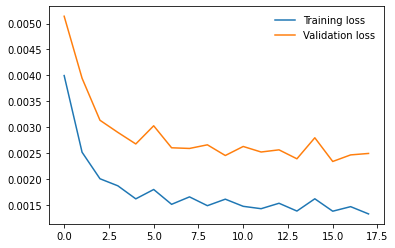

In [126]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [127]:
torch.save(model,'/content/PneumoniaClassifier_reset3.pt')
correct =0
total =0
with torch.no_grad():
  model.to("cpu")
  for i in tqdm(range(len(X_test))):
    real_class = y_test[i]
    net_out = model(X_test[i].view(-1,3,200,200).float())[0]
    predicted_class = torch.argmax(net_out)
    if predicted_class == real_class:
      correct +=1
    total +=1
print("Accruracy is"+str(round(correct/total*100,3)))

100%|██████████| 1171/1171 [04:39<00:00,  4.20it/s]

Accruracy is73.015


In [0]:
model.to("cpu")
torch.save(model,'/content/PneumoniaClassifier_reset3.pt')

In [0]:
from google.colab import files
files.download('/content/PneumoniaClassifier_reset3.pt')